## Setup

Importing course material modules and libraries

In [1]:
import random
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import math
import time
from math import exp, floor

# Set Seaborn theme for scientific publication quality figures
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

NUM_NODES = 50
# Use a fixed seed for reproducibility
G = nx.erdos_renyi_graph(n=NUM_NODES, p=0.1, seed=42)
NODES = list(G.nodes)

## Helper Functions (Moves and Neighbourhoods)
Simulated Annealing and Tabu search require a "move" or "neighbourhood" concept, this will help with the permutations.

In [2]:
def random_swap(path):
    """Returns a NEW path with two random nodes swapped (for SA)."""
    new_path = path.copy()
    i, j = random.sample(range(len(path)), 2)
    new_path[i], new_path[j] = new_path[j], new_path[i]
    return new_path

def get_neighborhood(path):
    """
    Returns a list of neighbors for Tabu.
    Instead of just adjacent swaps, we sample 50 random swaps 
    to allow larger jumps across the solution space.
    """
    neighbors = []
    # Generate 50 random neighbors (stochastic hill climbing)
    # This prevents being trapped by the "only adjacent" restriction
    for _ in range(50):
        neighbors.append(random_swap(path))
    return neighbors

## Fitness Functions

In [3]:
# --- UPDATED FITNESS FUNCTIONS (Graph Agnostic) ---

def count_edges(path, graph):
    """Counts valid edges in the path for a specific graph."""
    edges = 0
    for i in range(len(path) - 1):
        if graph.has_edge(path[i], path[i+1]):
            edges += 1
    return edges

def fitness_min(path, graph):
    """Minimisation: Returns number of broken edges. Target = 0."""
    target = len(path) - 1
    valid = count_edges(path, graph)
    return float(target - valid)

def fitness_max(path, graph):
    """Maximisation: Returns number of valid edges. Target = N-1."""
    return float(count_edges(path, graph))

def get_initial_solution(nodes):
    """Returns a random permutation."""
    p = list(nodes).copy()
    random.shuffle(p)
    return p

## Simulated Annealing, Tabu Search, Genetic Algorithm

In [4]:
def run_simulated_annealing(graph, max_steps=3000, temp0=100.0, verbose=False):
    if verbose: print("Running SA...")
    nodes = list(graph.nodes)
    current = get_initial_solution(nodes)
    best = current.copy()
    
    current_cost = fitness_min(current, graph)
    best_cost = current_cost
    trace = [best_cost]
    temp = temp0
    
    for step in range(max_steps):
        if best_cost == 0: break
            
        # Neighbor (Swap)
        neighbor = current.copy()
        i, j = random.sample(range(len(neighbor)), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        
        neighbor_cost = fitness_min(neighbor, graph)
        delta = neighbor_cost - current_cost
        
        if delta < 0 or random.random() < exp(-delta / temp):
            current = neighbor
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best = current.copy()
                best_cost = current_cost
        
        trace.append(best_cost)
        temp *= 0.985
        
    return best, best_cost, trace

def run_tabu_search(graph, max_steps=1000, tenure=20, verbose=False):
    if verbose: print("Running Tabu...")
    nodes = list(graph.nodes)
    current = get_initial_solution(nodes)
    best = current.copy()
    best_cost = fitness_min(best, graph)
    
    tabu_list = []
    trace = [best_cost]
    
    for step in range(max_steps):
        if best_cost == 0: break
            
        candidates = []
        # Generate 50 random neighbors
        for _ in range(50):
            cand = current.copy()
            i, j = random.sample(range(len(cand)), 2)
            cand[i], cand[j] = cand[j], cand[i]
            candidates.append(cand)
            
        candidates.sort(key=lambda p: fitness_min(p, graph))
        
        found_move = False
        for cand in candidates:
            cand_cost = fitness_min(cand, graph)
            if cand_cost < best_cost: # Aspiration
                current = cand
                best = cand
                best_cost = cand_cost
                found_move = True
                break
            if cand not in tabu_list:
                current = cand
                found_move = True
                break
        
        trace.append(best_cost)
        if found_move:
            tabu_list.append(current)
            if len(tabu_list) > tenure: tabu_list.pop(0)

    return best, best_cost, trace

def run_genetic_algorithm(graph, pop_size=200, generations=1000, cross_rate=0.8, mut_rate=0.3, verbose=False):
    if verbose: print("Running GA...")
    nodes = list(graph.nodes)
    target = len(nodes) - 1
    
    def ordered_crossover(p1, p2):
        size = len(p1)
        start, end = sorted(random.sample(range(size), 2))
        child = [None] * size
        child[start:end] = p1[start:end]
        current_p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while p2[current_p2_idx] in child:
                    current_p2_idx += 1
                child[i] = p2[current_p2_idx]
        return child

    def swap_mutation(genome):
        i, j = random.sample(range(len(genome)), 2)
        genome[i], genome[j] = genome[j], genome[i]
        return genome

    population = [get_initial_solution(nodes) for _ in range(pop_size)]
    best_sol = None
    best_broken = float('inf')
    trace = [] 

    for gen in range(generations):
        fitnesses = [fitness_max(p, graph) for p in population]
        best_val = max(fitnesses)
        current_broken = target - best_val
        
        if current_broken < best_broken:
            best_broken = current_broken
            best_sol = population[fitnesses.index(best_val)]
        
        # FIX: Append ONLY the scalar value, not a tuple
        trace.append(best_broken)
        
        if current_broken == 0: break
            
        next_pop = [best_sol] # Elitism
        while len(next_pop) < pop_size:
            competitors = random.sample(population, 3)
            winner = max(competitors, key=lambda p: fitness_max(p, graph))
            next_pop.append(winner)
        population = next_pop

        for i in range(1, pop_size - 1, 2):
            if random.random() < cross_rate:
                population[i] = ordered_crossover(population[i], population[i+1])
                
        for i in range(1, pop_size):
            if random.random() < mut_rate:
                population[i] = swap_mutation(population[i])

    return best_sol, best_broken, trace

## Brute Force (Ground Truth Approach)

--- VALIDATION TEST (N=10) ---
Brute Force: Checking all permutations for N=10...
Brute Force Result: 6 broken edges.


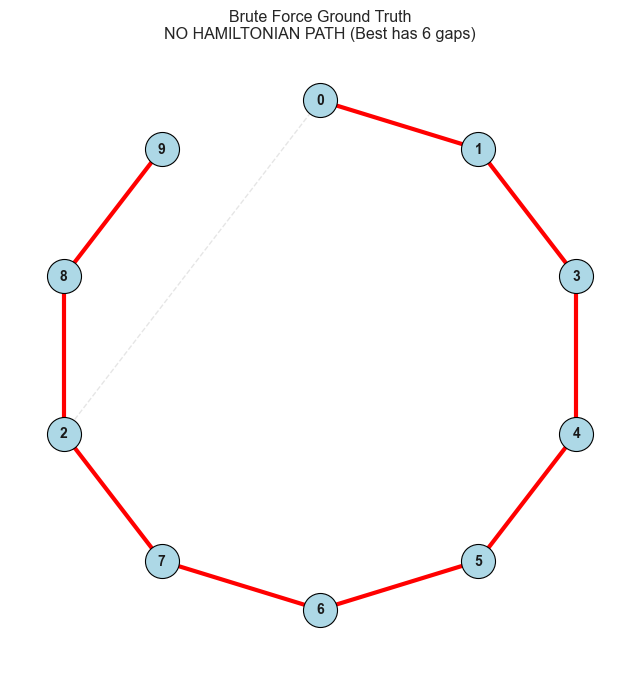

In [5]:
# --- BRUTE FORCE VALIDATION (Small Scale) ---
SMALL_N = 10
G_small = nx.erdos_renyi_graph(n=SMALL_N, p=0.1, seed=999)
small_nodes = list(G_small.nodes)

def brute_force_solver(graph, nodes):
    """
    Generates all permutations to find the Hamiltonian path.
    Returns: (best_path, broken_edges)
    """
    # N=10 is 3.6 million permutations.
    print(f"Brute Force: Checking all permutations for N={len(nodes)}...")
    
    best_path = None
    min_broken = float('inf')
    
    # Iterate through ALL possible permutations
    for path in itertools.permutations(nodes):
        broken = 0
        # Calculate broken edges
        for i in range(len(path) - 1):
            if not graph.has_edge(path[i], path[i+1]):
                broken += 1
                # Pruning: stop if this path is already worse than our best
                if broken >= min_broken:
                    break
        
        if broken < min_broken:
            min_broken = broken
            best_path = path
            if min_broken == 0: 
                break # Perfect solution found
                
    return best_path, min_broken

# 1. Run Solver
print(f"--- VALIDATION TEST (N={SMALL_N}) ---")
bf_path, bf_score = brute_force_solver(G_small, small_nodes)
print(f"Brute Force Result: {bf_score} broken edges.")

# 2. Visualise Result
if bf_path:
    plt.figure(figsize=(8, 8))
    
    # Custom Layout: Order nodes in a circle based on the FOUND path
    pos_bf = {}
    N = len(bf_path)
    for i, node in enumerate(bf_path):
        angle = -2 * math.pi * i / N + math.pi/2 # Clockwise, starting top
        pos_bf[node] = (math.cos(angle), math.sin(angle))
        
    # Draw Background Edges (Grey dashed)
    path_edges_set = set()
    for i in range(len(bf_path)-1):
        path_edges_set.add(tuple(sorted((bf_path[i], bf_path[i+1]))))
    
    non_path_edges = [
        (u, v) for u, v in G_small.edges() 
        if tuple(sorted((u, v))) not in path_edges_set
    ]
    
    nx.draw_networkx_edges(G_small, pos_bf, edgelist=non_path_edges, 
                          alpha=0.2, edge_color='grey', style='dashed')
    
    # Draw Nodes
    nx.draw_networkx_nodes(G_small, pos_bf, node_size=600, 
                          node_color='lightblue', edgecolors='black')
    
    # Draw Solution Path (Red)
    path_edges = [(bf_path[i], bf_path[i+1]) for i in range(len(bf_path)-1)]
    nx.draw_networkx_edges(G_small, pos_bf, edgelist=path_edges, 
                          edge_color='red', width=3)
    
    # Labels
    nx.draw_networkx_labels(G_small, pos_bf, font_size=10, font_weight='bold')
    
    title = "Brute Force Ground Truth\n"
    title += "PERFECT PATH FOUND" if bf_score == 0 else f"NO HAMILTONIAN PATH (Best has {bf_score} gaps)"
    plt.title(title)
    plt.axis('off')
    plt.show()

# Scientific Experiment

--- Batch Testing SA (30 runs) ---
SA: Mean Cost=13.13, Success=0.0%, Mean Time=0.0127s
--- Batch Testing Tabu (30 runs) ---
Tabu: Mean Cost=8.47, Success=0.0%, Mean Time=0.4648s
--- Batch Testing GA (30 runs) ---
GA: Mean Cost=7.63, Success=0.0%, Mean Time=6.5779s


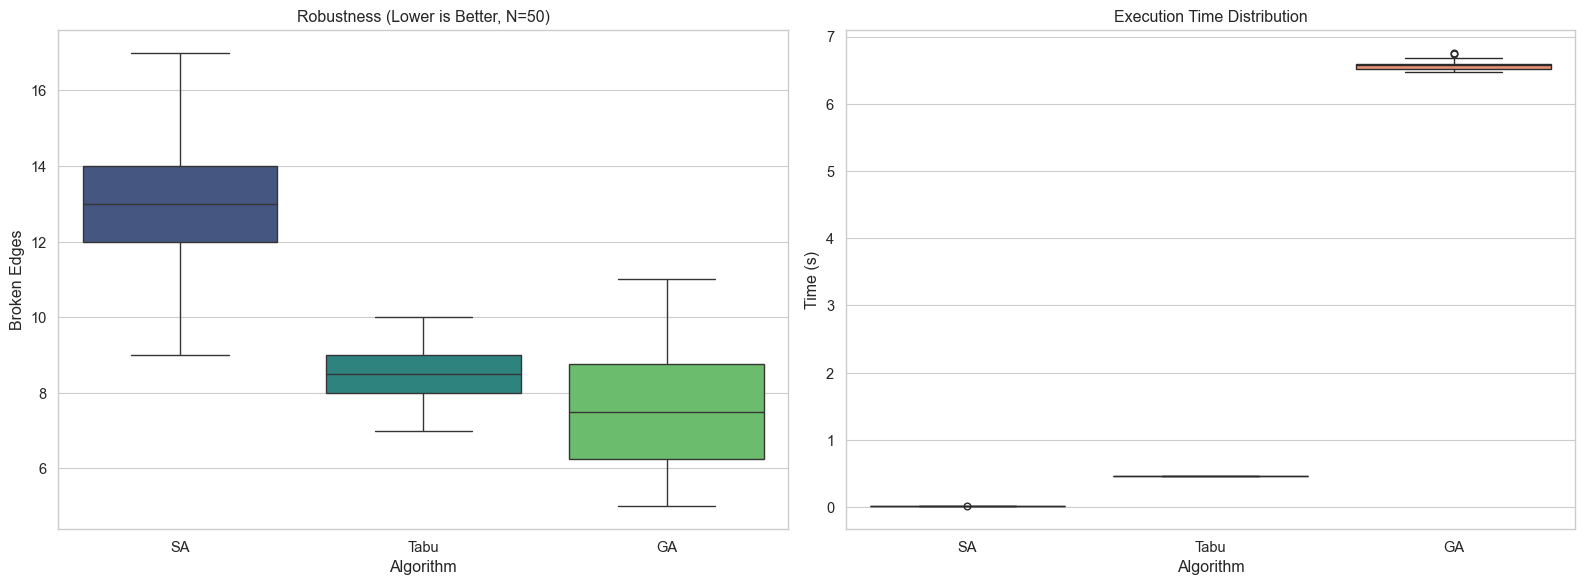

In [6]:
# --- EXPERIMENTAL SUITE WITH TIMING ---

def run_experiment_batch(algorithm_func, graph, n_trials=30, name="Algo"):
    """Runs an algorithm N times and returns stats including time."""
    print(f"--- Batch Testing {name} ({n_trials} runs) ---")
    scores = []
    times = []
    successes = 0
    
    for i in range(n_trials):
        start_time = time.time()
        # Run algorithm
        _, final_cost, _ = algorithm_func(graph)
        end_time = time.time()
        
        duration = end_time - start_time
        scores.append(final_cost)
        times.append(duration)
        
        if final_cost == 0:
            successes += 1
            
    success_rate = (successes / n_trials) * 100
    mean_time = np.mean(times)
    print(f"{name}: Mean Cost={np.mean(scores):.2f}, Success={success_rate:.1f}%, Mean Time={mean_time:.4f}s")
    
    return scores, times, success_rate

# 1. Setup Graph
NUM_NODES = 50
G_EXP = nx.erdos_renyi_graph(n=NUM_NODES, p=0.1, seed=42)

# 2. Run Batches
sa_scores, sa_times, _ = run_experiment_batch(
    lambda g: run_simulated_annealing(g, max_steps=2000), G_EXP, name="SA")

tabu_scores, tabu_times, _ = run_experiment_batch(
    lambda g: run_tabu_search(g, max_steps=1500), G_EXP, name="Tabu")

ga_scores, ga_times, _ = run_experiment_batch(
    lambda g: run_genetic_algorithm(g, generations=1000), G_EXP, name="GA")

# 3. Create DataFrame for Seaborn
data = {
    'Algorithm': ['SA']*30 + ['Tabu']*30 + ['GA']*30,
    'Broken Edges': sa_scores + tabu_scores + ga_scores,
    'Time (s)': sa_times + tabu_times + ga_times
}
df_exp = pd.DataFrame(data)

# 4. Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Solution Quality (Boxplot) - Fixed warning by mapping x to hue
sns.boxplot(data=df_exp, x='Algorithm', y='Broken Edges', hue='Algorithm', 
            legend=False, ax=axes[0], palette="viridis")
axes[0].set_title(f'Robustness (Lower is Better, N={NUM_NODES})')

# Plot 2: Execution Time (Boxplot) - Fixed warning by mapping x to hue
sns.boxplot(data=df_exp, x='Algorithm', y='Time (s)', hue='Algorithm', 
            legend=False, ax=axes[1], palette="magma")
axes[1].set_title('Execution Time Distribution')

plt.tight_layout()
plt.show()

# Optimisation Evaluation

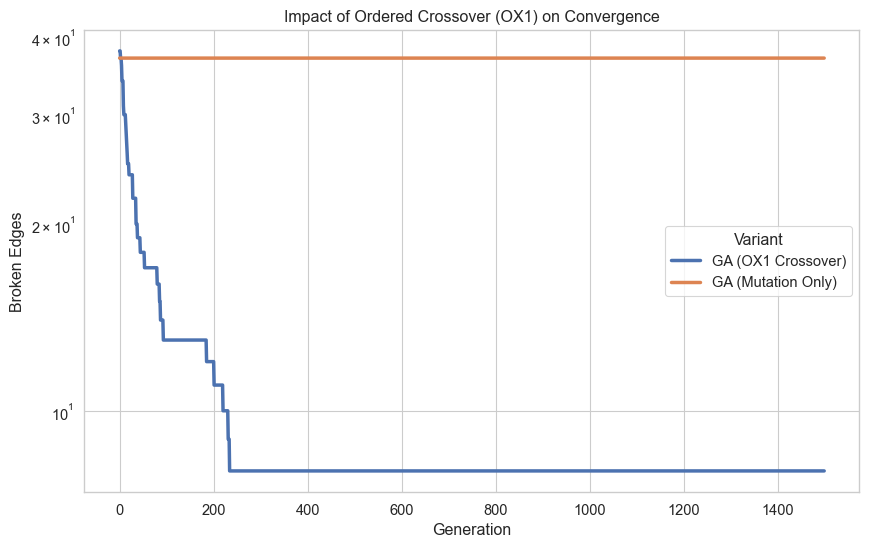

In [7]:
# --- OPTIMISATION: Crossover vs Mutation Only ---

# Run traces
_, _, trace_ox1 = run_genetic_algorithm(G_EXP, generations=1500, cross_rate=0.9, mut_rate=0.1)
_, _, trace_mut = run_genetic_algorithm(G_EXP, generations=1500, cross_rate=0.0, mut_rate=0.5)

# Prepare Data for Seaborn
df_opt = pd.DataFrame({
    'Generation': list(range(len(trace_ox1))) + list(range(len(trace_mut))),
    'Broken Edges': trace_ox1 + trace_mut,
    'Variant': ['GA (OX1 Crossover)'] * len(trace_ox1) + ['GA (Mutation Only)'] * len(trace_mut)
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_opt, x='Generation', y='Broken Edges', hue='Variant', linewidth=2.5)
plt.title('Impact of Ordered Crossover (OX1) on Convergence')
plt.yscale('log')
plt.show()

# Phase Transition Analysis

--- Running Phase Transition Sweep ---
Density p=0.05: Success Rate = 0.0%
Density p=0.08: Success Rate = 0.0%
Density p=0.1: Success Rate = 0.0%
Density p=0.15: Success Rate = 0.0%
Density p=0.2: Success Rate = 0.0%
Density p=0.3: Success Rate = 40.0%


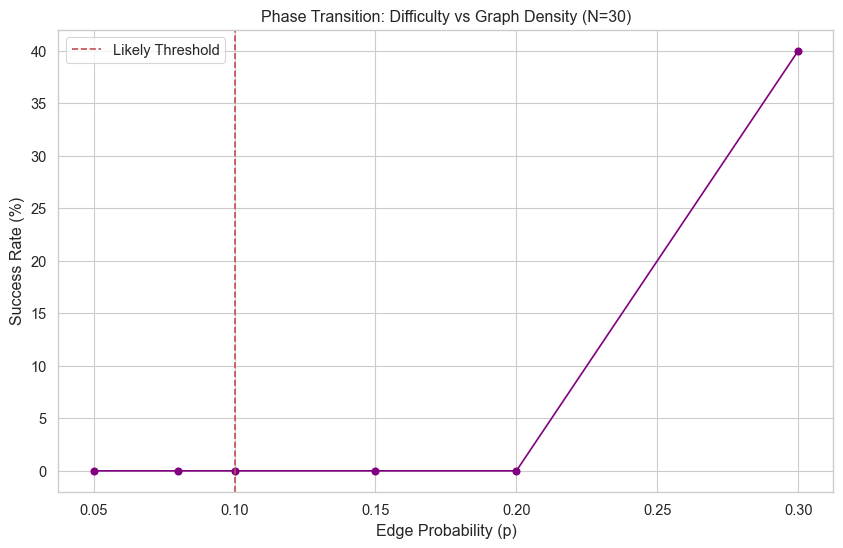

In [8]:
# --- PHASE TRANSITION ANALYSIS ---
# How does edge probability 'p' affect solvability?

densities = [0.05, 0.08, 0.1, 0.15, 0.2, 0.3]
success_rates = []

print("--- Running Phase Transition Sweep ---")
for p in densities:
    # Generate new graph for this density
    g_temp = nx.erdos_renyi_graph(n=30, p=p, seed=999) # Smaller N=30 for speed
    
    # Run a batch (e.g., 10 runs per density)
    # Using SA here as it's fast, or GA if you prefer
    success_count = 0
    num_runs = 10
    for _ in range(num_runs):
        _, cost, _ = run_simulated_annealing(g_temp, max_steps=2000)
        if cost == 0:
            success_count += 1
            
    rate = (success_count / num_runs) * 100
    success_rates.append(rate)
    print(f"Density p={p}: Success Rate = {rate}%")

plt.figure(figsize=(10, 6))
plt.plot(densities, success_rates, marker='o', color='purple')
plt.title('Phase Transition: Difficulty vs Graph Density (N=30)')
plt.xlabel('Edge Probability (p)')
plt.ylabel('Success Rate (%)')
plt.grid(True)
plt.axvline(x=0.1, color='r', linestyle='--', label='Likely Threshold')
plt.legend()
plt.show()

# Pyvis experiment

In [9]:
# --- FINAL VISUALISATION: The Best Found Path ---
from pyvis.network import Network

# 1. Get a solution using the best algorithm (likely GA)
print("Generating final solution for visualization...")
final_path, final_cost, _ = run_genetic_algorithm(G_EXP, generations=2000)
print(f"Final Path Cost: {final_cost}")

# 2. Setup Pyvis
try:
    net = Network(notebook=True, height="600px", width="100%", cdn_resources='remote')
    
    # Add all nodes from original graph
    for node in G_EXP.nodes:
        net.add_node(int(node), label=str(node), color='#97c2fc')

    # Add edges from original graph (grey)
    for u, v in G_EXP.edges:
        net.add_edge(int(u), int(v), color='#e0e0e0', width=1)

    # Highlight the found path (Red)
    for i in range(len(final_path) - 1):
        u, v = int(final_path[i]), int(final_path[i+1])
        # Check if valid edge exists in graph
        if G_EXP.has_edge(u, v):
            net.add_edge(u, v, color='red', width=4)
        else:
            # If edge is broken/missing, show as dashed red
            net.add_edge(u, v, color='red', width=4, dashes=True)

    net.show("hamiltonian_path.html")
    print("Graph saved to hamiltonian_path.html")

except ImportError:
    print("Pyvis not installed. Skipping visualization.")

Generating final solution for visualization...
Final Path Cost: 6.0
hamiltonian_path.html
Graph saved to hamiltonian_path.html
